SIMULACIÓN DE MONITOREO DE DERIVA
Referencia (entrenamiento): (642, 15)
Actual (producción): (276, 15)

ANÁLISIS DE DERIVA POR FEATURE:
    Age                 : -2.0%
    RestingBP           : +0.6%
    Cholesterol         : -5.8%
     FastingBS           : +15.5%
    MaxHR               : +1.7%
    Oldpeak             : +1.6%
    Sex_M               : +1.3%
     ChestPainType_ATA   : +17.3%
     ChestPainType_NAP   : +12.1%
     ChestPainType_TA    : -35.4%
    RestingECG_Normal   : -4.2%
    RestingECG_ST       : +6.8%
    ExerciseAngina_Y    : -8.2%
    ST_Slope_Flat       : -5.4%
    ST_Slope_Up         : +7.7%

RESUMEN DE DERIVA:
   Total features: 15
   Features con deriva (>10%): 4
   Features estables: 11


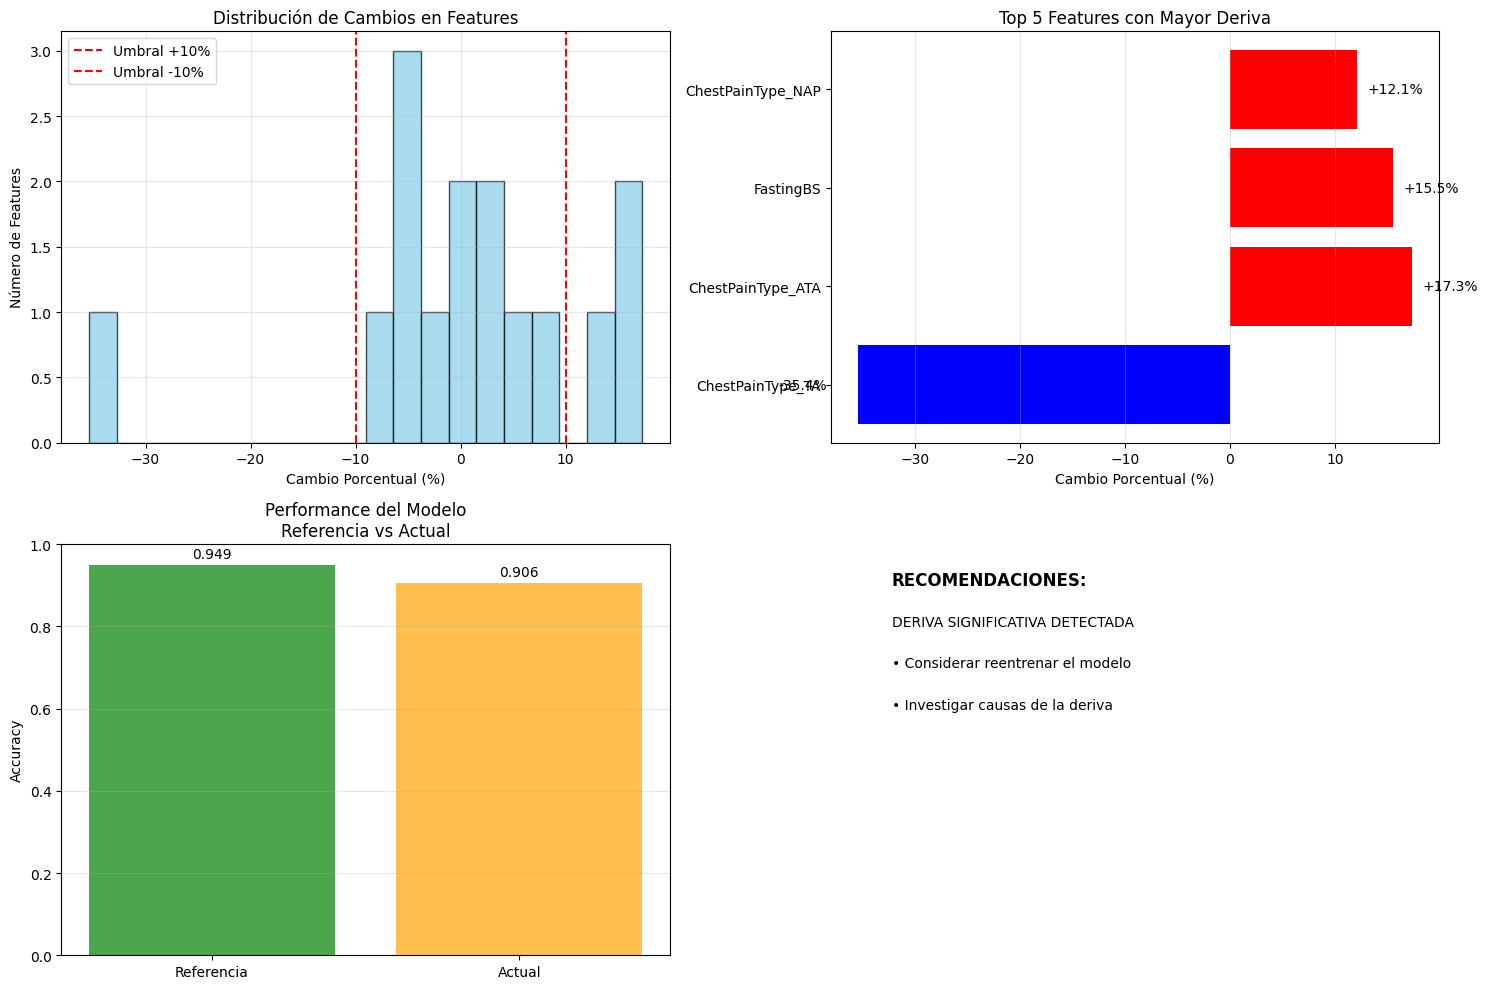


RECOMENDACIONES FINALES:
    DERIVA SIGNIFICATIVA - Considerar reentrenamiento

Métricas clave:
   • Accuracy referencia: 0.949
   • Accuracy actual: 0.906
   • Diferencia: -0.043


In [2]:
# notebooks/3_data_drift_monitoring.ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import joblib

df = pd.read_csv("heart.csv")

# Detectar target
def detect_target_column(df):
    possible_targets = ['HeartDisease', 'target', 'disease', 'class', 'output']
    for col in possible_targets:
        if col in df.columns:
            return col
    return df.columns[-1]

target_column = detect_target_column(df)
X = df.drop(target_column, axis=1)
y = df[target_column]

# Preprocesamiento
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Simular datos de referencia vs actual (producción)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, random_state=42, stratify=y
)

print("SIMULACIÓN DE MONITOREO DE DERIVA")
print(f"Referencia (entrenamiento): {X_train.shape}")
print(f"Actual (producción): {X_test.shape}")

# Cargar modelo
model = joblib.load("app/model.joblib")

# Análisis de deriva básico
def analyze_drift(reference, current):
    """Análisis básico de deriva de datos"""
    print("\nANÁLISIS DE DERIVA POR FEATURE:")
    
    drift_results = []
    
    for col in reference.columns:
        ref_mean = reference[col].mean()
        curr_mean = current[col].mean()
        change_pct = ((curr_mean - ref_mean) / ref_mean) * 100 if ref_mean != 0 else 0
        
        drift_results.append({
            'feature': col,
            'ref_mean': ref_mean,
            'curr_mean': curr_mean,
            'change_pct': change_pct,
            'has_drift': abs(change_pct) > 10  # Umbral del 10%
        })
        
        status = " " if abs(change_pct) > 10 else ""
        print(f"   {status} {col:20}: {change_pct:+.1f}%")
    
    return drift_results

# Ejecutar análisis
drift_results = analyze_drift(X_train, X_test)

# Resumen
drift_count = sum(1 for r in drift_results if r['has_drift'])
total_features = len(drift_results)

print(f"\nRESUMEN DE DERIVA:")
print(f"   Total features: {total_features}")
print(f"   Features con deriva (>10%): {drift_count}")
print(f"   Features estables: {total_features - drift_count}")

# Visualización
plt.figure(figsize=(15, 10))

# Gráfico 1: Distribución de cambios
changes = [r['change_pct'] for r in drift_results]
plt.subplot(2, 2, 1)
plt.hist(changes, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=10, color='red', linestyle='--', label='Umbral +10%')
plt.axvline(x=-10, color='red', linestyle='--', label='Umbral -10%')
plt.xlabel('Cambio Porcentual (%)')
plt.ylabel('Número de Features')
plt.title('Distribución de Cambios en Features')
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico 2: Features con mayor deriva
top_drift = sorted([r for r in drift_results if r['has_drift']], 
                   key=lambda x: abs(x['change_pct']), reverse=True)[:5]

if top_drift:
    features = [r['feature'] for r in top_drift]
    changes = [r['change_pct'] for r in top_drift]
    
    plt.subplot(2, 2, 2)
    bars = plt.barh(features, changes, color=['red' if c > 0 else 'blue' for c in changes])
    plt.xlabel('Cambio Porcentual (%)')
    plt.title('Top 5 Features con Mayor Deriva')
    plt.grid(True, alpha=0.3, axis='x')
    
    # Añadir valores
    for bar, change in zip(bars, changes):
        plt.text(bar.get_width() + (1 if change > 0 else -3), 
                bar.get_y() + bar.get_height()/2, 
                f'{change:+.1f}%', 
                va='center', ha='left' if change > 0 else 'right')

# Gráfico 3: Performance del modelo
plt.subplot(2, 2, 3)
# Performance en datos de referencia vs actual
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)

accuracies = [train_acc, test_acc]
labels = ['Referencia', 'Actual']

bars = plt.bar(labels, accuracies, color=['green', 'orange'], alpha=0.7)
plt.ylabel('Accuracy')
plt.title('Performance del Modelo\nReferencia vs Actual')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3, axis='y')

# Añadir valores
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom')

# Gráfico 4: Recomendaciones
plt.subplot(2, 2, 4)
plt.axis('off')

recommendations = []
if drift_count / total_features > 0.2:
    recommendations.append("DERIVA SIGNIFICATIVA DETECTADA")
    recommendations.append("• Considerar reentrenar el modelo")
    recommendations.append("• Investigar causas de la deriva")
elif drift_count / total_features > 0.1:
    recommendations.append("DERIVA MODERADA DETECTADA") 
    recommendations.append("• Monitorear continuamente")
    recommendations.append("• Preparar reentrenamiento")
else:
    recommendations.append("DERIVA MÍNIMA")
    recommendations.append("• Modelo estable")
    recommendations.append("• Continuar monitoreo")

plt.text(0.1, 0.9, "RECOMENDACIONES:", fontsize=12, fontweight='bold')
for i, rec in enumerate(recommendations):
    plt.text(0.1, 0.8 - i*0.1, rec, fontsize=10)

plt.tight_layout()
plt.show()

print("\nRECOMENDACIONES FINALES:")
if drift_count / total_features > 0.2:
    print("    DERIVA SIGNIFICATIVA - Considerar reentrenamiento")
elif drift_count / total_features > 0.1:
    print("    DERIVA MODERADA - Monitorear de cerca") 
else:
    print("    DERIVA MÍNIMA - Modelo estable")

print(f"\nMétricas clave:")
print(f"   • Accuracy referencia: {train_acc:.3f}")
print(f"   • Accuracy actual: {test_acc:.3f}")
print(f"   • Diferencia: {test_acc - train_acc:+.3f}")